# Time series to images

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.6 MB/s eta 0:00:00


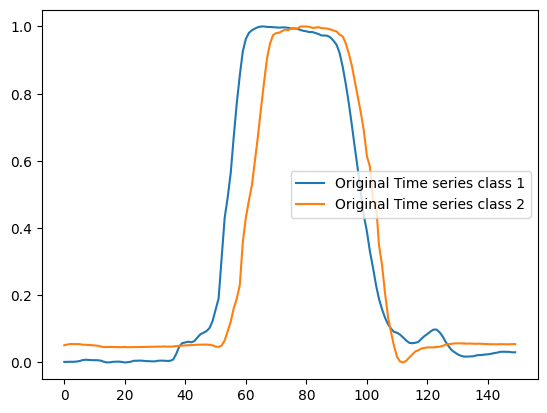

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

!pip install -U aeon
from aeon.datasets import load_classification

import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""# Dataset"""

X, y = load_classification(name="GunPoint")
y_reduced = y.copy()
X_reduced = X.copy()

"""## Convert time series into images"""

from scipy import signal

#Normalise
a=0
b=1
X_normalized = []
for el in X :
  max = np.max(el)
  min = np.min(el)
  X_normalized.append((el - min) / (max - min) * (b - a) + a)

time_series_class_2 = X_normalized[0]
time_series_class_1 = X_normalized[2]


plt.plot(time_series_class_1[0], label=f'Original Time series class 1')
plt.plot(time_series_class_2[0], label=f'Original Time series class 2')
plt.legend()

!pip install -U pyts
from pyts.image import GramianAngularField

np.shape(X_normalized)

# Set parameters for Gramian Angular Field
image_size = 1.0
sample_range = (-1, 1)
method = 'summation'  # Other options: 'difference', 'product', 'double_summation'

# Create Gramian Angular Field transformer
gaf = GramianAngularField(image_size=image_size, sample_range=sample_range, method=method)

# Transform time series to GAF
gaf_images_X = []
for el in X_normalized:
  gaf_images_X.append(gaf.fit_transform(el))
gaf_image_class_1 = gaf_images_X[0]
gaf_image_class_2 = gaf_images_X[2]




# Print images of both classes

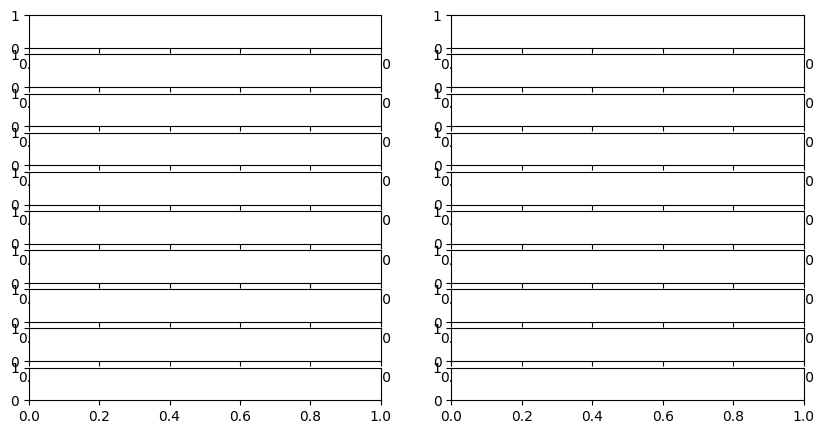

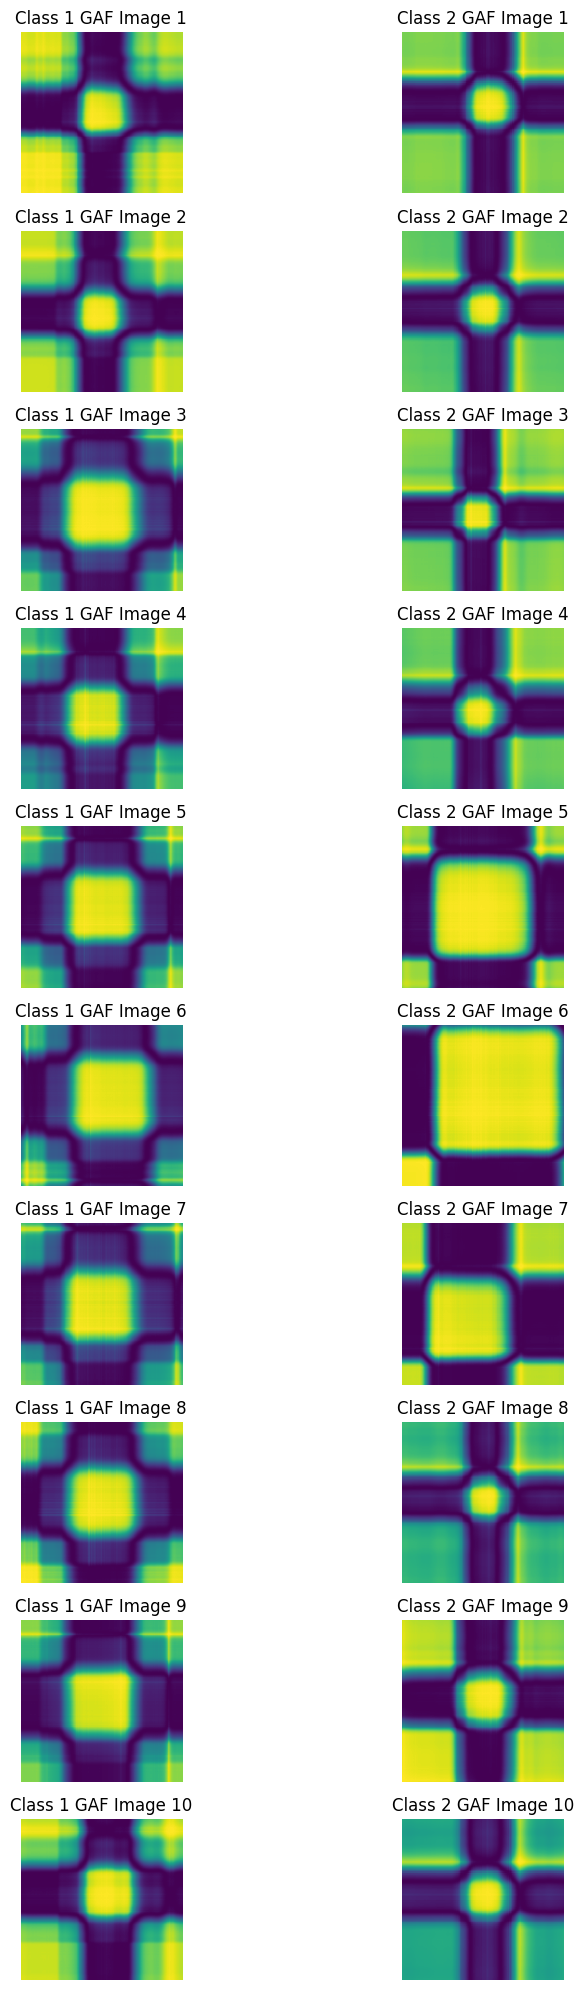

In [ ]:
gaf_images_X = np.array(gaf_images_X)


class_1_images = []
class_2_images = []

for i in range(40):
  if y_reduced[i].astype(int) == 1 :
    class_1_images.append(gaf_images_X[i][0])
  else :
    class_2_images.append(gaf_images_X[i][0])


class_1_images = class_1_images[:10]
class_2_images = class_2_images[:10]


# Create subplots
fig, axs = plt.subplots(10, 2, figsize=(10, 5))


# Assuming class_1_images and class_2_images contain the desired images as numpy arrays
fig, axs = plt.subplots(10, 2, figsize=(10, 20))  # Adjust size as needed

for i in range(10):
    # Display class 1 images in the first column
    axs[i, 0].imshow(class_1_images[i], cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
    axs[i, 0].set_title(f'Class 1 GAF Image {i+1}')
    axs[i, 0].axis('off')  # Optional: Remove axes for cleaner look

    # Display class 2 images in the second column, if you have enough class 2 images
    axs[i, 1].imshow(class_2_images[i], cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
    axs[i, 1].set_title(f'Class 2 GAF Image {i+1}')
    axs[i, 1].axis('off')  # Optional: Remove axes for cleaner look

plt.tight_layout()  # Adjust layout to make room for titles
plt.show()



# VQ VAE Model



In [ ]:
# Ported from: https://github.com/deepmind/sonnet/blob/v2/examples/vqvae_example.ipynb.

import torch

from torch import nn
from torch.nn import functional as F


class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        #print("Input :", x.size())
        h = self.conv(x)
        #print("After encoder :", h.size())
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )

        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):

            if upsampling_layer < num_upsampling_layers - 2:

                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:

                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            else:
                (in_channels, out_channels) = (num_hiddens // 2, 3)

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=1,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        upconv.add_module(
            f"up{upsampling_layer}",
            nn.Upsample(size=[150,150])
        ),
        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        #print("After conv (dec):", h.size())
        h = self.residual_stack(h)
        #print("After stack (dec):", h.size())
        x_recon = self.upconv(h)
        #print("After upconv (dec):", x_recon.size())
        return x_recon


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay ** self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3 ** 0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x ** 2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts ** 2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }

# Training

In [ ]:
# See: https://github.com/deepmind/sonnet/blob/v2/examples/vqvae_example.ipynb.

import numpy as np
import torch

from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

torch.set_printoptions(linewidth=160)


# Initialize model.
#device = torch.device("cuda:0")
use_ema = True
model_args = {
    "in_channels": 1,
    "num_hiddens": 128,
    "num_downsampling_layers": 2,
    "num_residual_layers": 2,
    "num_residual_hiddens": 32,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "use_ema": use_ema,
    "decay": 0.99,
    "epsilon": 1e-5,
}
model = VQVAE(**model_args)
model.to(device)

# Initialize dataset.
batch_size = 16
#workers = 10

#print(gaf_images_X.shape)
y = y.astype(int)
# Convert the data to PyTorch tensors
X_tensor = torch.tensor(gaf_images_X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# Take 160 elements for training, 40 for testing
indices = torch.randperm(len(X_tensor))[:160]
mask = torch.ones(len(X_tensor), dtype=torch.bool)
mask[indices] = False

X_tensor_test = X_tensor[mask]
y_tensor_test = y_tensor[mask]
X_tensor_train = X_tensor[indices]
y_tensor_train = y_tensor[indices]

#print("Input :", X_tensor.size())


# Create a TensorDataset and DataLoader
# Train part
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
#train_data_variance = np.var(train_dataset.data / 255)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
# Test part
test_dataset = TensorDataset(X_tensor_test, y_tensor_test)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
)



# Multiplier for commitment loss. See Equation (3) in "Neural Discrete Representation
# Learning".
beta = 0.5

# Initialize optimizer.
train_params = [params for params in model.parameters()]
lr = 3e-4
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()


# Function to evaluate model on test set
def evaluate_model(model, test_loader, criterion, beta, device):
    model.eval()
    total_test_loss = 0
    total_recon_error = 0
    with torch.no_grad():
        for test_tensors in test_loader:
            imgs = test_tensors[0].to(device)
            out = model(imgs)
            recon_error = criterion(out["x_recon"], imgs)
            total_recon_error += recon_error.item()
            loss = recon_error + beta * out["commitment_loss"]
            if not use_ema:
                loss += out["dictionary_loss"]
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    avg_recon_error = total_recon_error / len(test_loader)
    return avg_test_loss, avg_recon_error

# Training loop
epochs = 30
eval_every = 2
best_train_loss = float("inf")

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    total_recon_error = 0
    n_train = 0
    for (batch_idx, train_tensors) in enumerate(train_loader):
        optimizer.zero_grad()
        imgs = train_tensors[0].to(device)
        out = model(imgs)
        recon_error = criterion(out["x_recon"], imgs)
        total_recon_error += recon_error.item()
        loss = recon_error + beta * out["commitment_loss"]
        if not use_ema:
            loss += out["dictionary_loss"]
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        n_train += 1

    # Print training stats
    avg_train_loss = total_train_loss / n_train
    avg_recon_error = total_recon_error / n_train
    print(f'Epoch {epoch}: Avg Train Loss: {avg_train_loss}, Avg Recon Error: {avg_recon_error}')

    # Evaluation phase
    if (epoch + 1) % eval_every == 0:
        avg_test_loss, avg_test_recon_error = evaluate_model(model, test_loader, criterion, beta, device)
        print(f'**** Epoch {epoch}: Avg TEST Loss: {avg_test_loss}, Avg TEST Recon Error: {avg_test_recon_error}')


        if avg_test_loss < best_train_loss:
            best_train_loss = avg_test_loss


Epoch 0: Avg Train Loss: 0.979670250415802, Avg Recon Error: 0.9378238379955292
Epoch 1: Avg Train Loss: 0.6000724315643311, Avg Recon Error: 0.5603924930095673
**** Epoch 1: Avg TEST Loss: 0.5836894909540812, Avg TEST Recon Error: 0.5648060838381449
Epoch 2: Avg Train Loss: 0.5675709307193756, Avg Recon Error: 0.5589235782623291
Epoch 3: Avg Train Loss: 0.546522319316864, Avg Recon Error: 0.5440294861793518
**** Epoch 3: Avg TEST Loss: 0.5218748251597086, Avg TEST Recon Error: 0.5175735652446747
Epoch 4: Avg Train Loss: 0.520622918009758, Avg Recon Error: 0.5127073109149933
Epoch 5: Avg Train Loss: 0.4711094558238983, Avg Recon Error: 0.4656773805618286
**** Epoch 5: Avg TEST Loss: 0.42075344920158386, Avg TEST Recon Error: 0.4122063418229421
Epoch 6: Avg Train Loss: 0.4204385817050934, Avg Recon Error: 0.4127029150724411
Epoch 7: Avg Train Loss: 0.40374492704868314, Avg Recon Error: 0.40170269310474394
**** Epoch 7: Avg TEST Loss: 0.3733454744021098, Avg TEST Recon Error: 0.371753036

## Evaluation

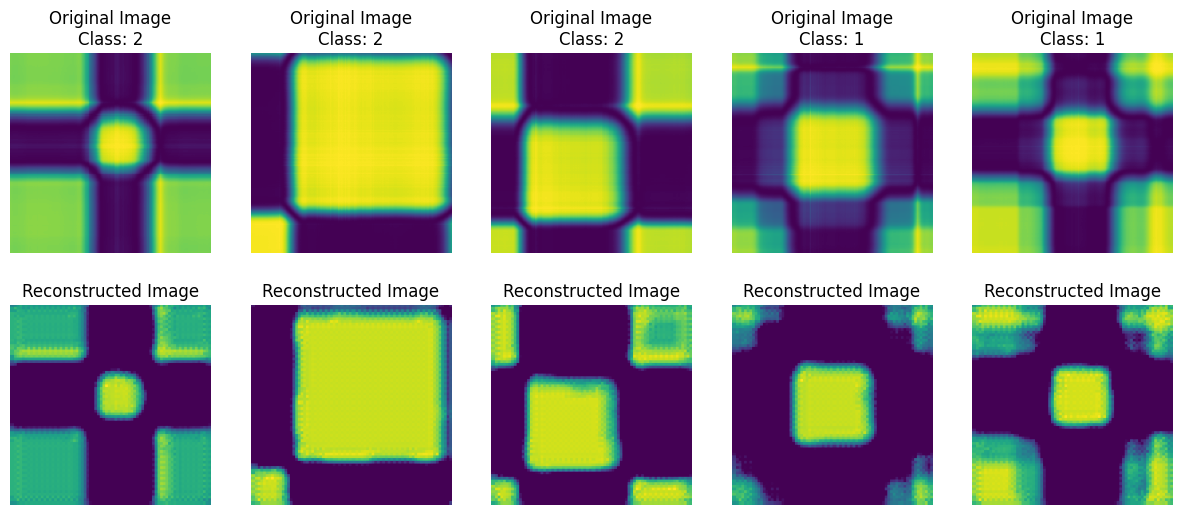

In [ ]:
# Generate and save reconstructions.
model.eval()

with torch.no_grad():
  for valid_tensors in test_loader:
      break


recon_tensors = model(valid_tensors[0].to(device))["x_recon"]
initial_tensors = valid_tensors[0].to(device)
labels = valid_tensors[1].to(device)


recon_imgs_array = recon_tensors.detach().cpu().numpy()
initial_imgs_array = initial_tensors.detach().cpu().numpy()
labels_array = labels.detach().cpu().numpy()


fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
  axs[0, i].imshow(initial_imgs_array[i].squeeze(), cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
  axs[0, i].set_title(f'Original Image\nClass: {labels_array[i]}')
  axs[0, i].axis('off')

  axs[1, i].imshow(recon_imgs_array[i].squeeze(), cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
  axs[1, i].set_title('Reconstructed Image')
  axs[1, i].axis('off')

plt.show()




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Retrieve data after quantize layer

In [ ]:
import torch
from collections import defaultdict

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dictionary to store mappings from quantized vectors to classes
vector_to_classes = defaultdict(list)

with torch.no_grad():
    quantized_vectors = []
    labels_list = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get quantized outputs and encoding indices
        z_quantized, _, _, encoding_indices = model.quantize(images)

        quantized_vectors.append(z_quantized.detach().cpu())
        labels_list.append(labels.detach().cpu())

        # Flatten the encoding indices and convert them to a list along with the labels
        for idx, label in zip(encoding_indices.flatten().tolist(), labels.tolist()):
            vector_to_classes[idx].append(label)
        # vector_to_classes now contains the mapping from each vector index to the lists of classes they're associated with

quantized_vectors_tensor = torch.cat(quantized_vectors, dim=0)
print(quantized_vectors_tensor.shape)
labels_tensor = torch.cat(labels_list, dim=0)


torch.save({
    'quantized_vectors': quantized_vectors_tensor,
    'labels': labels_tensor
}, '/content/drive/My Drive/ENSTA/Projet_IA_Gianni/quantized_dataset.pt')



torch.Size([40, 64, 37, 37])
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Analyze latent space

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize a dictionary to hold the frequencies in a sparse manner
vector_class_frequencies = defaultdict(lambda: defaultdict(int))

# This is where you fill the 'vector_to_classes' with your data
# vector_to_classes = {...} # Dictionary with your vector to classes mapping

# Update this to the actual number of classes you have
num_classes = 2

# Calculate the frequencies
for idx, classes in vector_to_classes.items():
    for class_label in classes:
        # Assuming class labels are 1-based, and you want to map class 2 to class 0
        adjusted_label = class_label - 1
        vector_class_frequencies[idx][adjusted_label] += 1

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
unique_indices = sorted(vector_class_frequencies.keys())
index_to_position = {index: pos for pos, index in enumerate(unique_indices)}
bar_width = 0.35
colors = ['blue', 'orange']  # Assuming two classes (you can add more colors if you have more classes)

# Plot the bars for each class
for class_label in range(num_classes):
    bar_heights = []
    for idx in unique_indices:
        bar_heights.append(vector_class_frequencies[idx][class_label])

    ax.bar([index_to_position[idx] + (bar_width * class_label) for idx in unique_indices],
           bar_heights, width=bar_width, color=colors[class_label], label=f'Class {class_label}')

# Set the x-ticks to the positions with the indices as labels
ax.set_xticks([index_to_position[idx] for idx in unique_indices])
ax.set_xticklabels(unique_indices)

# Optionally add labels and title
ax.set_xlabel('Quantized Vector Index')
ax.set_ylabel('Frequency')
ax.set_title('Class Distribution Across Quantized Vectors')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

